![image](../pic/pic1.jpg)
![image](../pic/pic2.jpg)

Длинные названия потому, что за жизненным циклом обектов следить не умею :)

Симулирую **ТОЛЬКО** создание новых связей

In [1]:
Generate_Network_t0 <- function(size = 40, sparsity = 0.7) {
	network <- matrix(0, nrow=size, ncol=size)
  
	for (i in 1:size) {
		for (j in 1:size) {
			if (runif(1) > sparsity) {
				network[i, j] <- 1
			}
		}
	}
  
	return(network)
}


Network_function_1 <- function(i, Network) { # outdegree (density)
	net <- sum(Network[i, ])
	return(net)
}


Network_function_2 <- function(i, Network) { # recip
	net <- 0
    for(j in 1:length(Network[1,])){
        if(i != j){
            net <- net + Network[i,j]*Network[j,i]
        }
    }
	return(net)
}

Network_function_3 <- function(i, Network) { # transitive triplets (transTrip)
	net <- 0
	for (j in 1:length(Network[i, ])) {
		for(h in 1:length(Network[, j])){
			if(i!=j & j!=h & i!=h){
                
				net <- net + (Network[i,j] * Network[i,h] * Network[h,j]) 
			}
		}
	}
	return(net)
}

Generate_Possible_Ministep_Matrix_vector <- function(i, Network) {
	Networks <- list()
  
	for (j in 1:length(Network[i, ])) {
		if (i != j) {
			TMP_Net <- Network
			TMP_Net[i, j] <- 1
			Networks[[j]] <- TMP_Net    
		}
	}
	return(Networks)
}

Ministep <- function(Network, i, j) {
	Network[i, j] <- 1
	return(Network)
}


Distribution_actors <- function(i, Network, beta) {
	Util <- numeric( length(Network[i, ]) )
	total_util <- 0
  
	for (h in 1:length(Network[i, ])) {
		if (i != h) {
			total_util <- total_util + exp(Utility(Network, beta, i, h))
		}
	}
  
	Util_j <- numeric(length(Network[i, ]))
  
	for (j in 1:length(Network[i, ])) {
		if (j != i) {
			Util_j[j] <- exp(Utility(Network, beta, i, j))
			Util[j] <- Util_j[j] / total_util
		}
        
	}
    Util[which(is.na(Util))] <- 0
	return(Util)
}

Utility <- function(Network, beta, i, j) {
	util <- 0
    NetIJ <- Generate_Possible_Ministep_Matrix_vector(i, Network)
	util <- util + (beta[1] * Network_function_2(i, NetIJ[[j]]))# + (beta[2] * Network_function_3(i, NetIJ[[j]]))
	return(util)
}

Simulator <- function(Network0, t = 0, LambdaV, total_Lambda, T, beta) {
	Network <- Network0 
	while (t < T) {
		deltaT <- rexp(1, rate=total_Lambda)
		i <- sample(1:length(Network0[1,]), size=1, prob=(LambdaV / total_Lambda))
      
		prob_vector <- 0
		prob_vector <- Distribution_actors(i, Network, beta)
		j <- sample(1:length(Network0[i, ]), size=1, prob=prob_vector)
		Network[i, j] <- 1
		t <- t + deltaT
        

	}
	return(Network)
}

In [2]:
size <- 20
Network0 <- Generate_Network_t0(size = size, sparsity = .7)
LambdaV <- rexp(n = size) 
total_Lambda <- sum(LambdaV)
# beta <- rexp(n = 2)
beta <- c(1.5, 1.8)
T <- 2.5

In [3]:
Network1 <- Simulator(Network0, t = 0, LambdaV, total_Lambda, T, beta)

In [4]:
Network2 <- Simulator(Network1, t = 0, LambdaV, total_Lambda, T, beta)

In [5]:
sum(Network0)
sum(Network1)
sum(Network2)

[1] 125

[1] 149

[1] 174

---
# Проверка в RSiena

In [6]:
library(RSiena)

In [7]:
# Забавно, но сиена так сходится
# Network0 <- Generate_Network_t0(size = size, sparsity = .6)
# Network1 <- Generate_Network_t0(size = size, sparsity = .7)
# Network2 <- Generate_Network_t0(size = size, sparsity = .8)

Networks <- array(c(Network0, Network1, Network2), dim = c(size, size, 3))

Networks <- sienaDependent(Networks, nodeSet="Actors")

Networks

Type         oneMode             
Observations 3                   
Nodeset      Actors (20 elements)


In [8]:
mydata <- sienaDataCreate(Networks)
myeff <- getEffects(mydata)
mydata

For dependent variable Networks, in some periods,

there are only increases, or only decreases.

This will be respected in the simulations. 

If this is not desired, use allowOnly=FALSE when creating the dependent variable.



Dependent variables:  Networks 
Number of observations: 3 

Nodeset                  Actors 
Number of nodes              20 

Dependent variable Networks      
Type               oneMode       
Observations       3             
Nodeset            Actors        
Densities          0.31 0.38 0.44

"uponly":  Networks:    all periods

Сиена видит коэффиценты разреженности. Они идентичны заданным.

Так же в предупреждении указано, что сеть только увеличивалась или уменьшалась, что корректно отвечает заданным условиям. 

In [9]:
effectsDocumentation(myeff,type = "html", display = FALSE)

Effects documentation written to file myeff.html .


In [10]:
myeff <- includeEffects(myeff, recip  , type = "creation", include = TRUE)
myeff <- includeEffects(myeff, recip  , type = "eval", include = FALSE)


myeff <- includeEffects(myeff, outRateLog , type = "rate", include = TRUE)

# myeff <- includeEffects(myeff, transTrip, type = "creation", include = TRUE)
# myeff <- includeEffects(myeff, transTrip, include = TRUE)

  effectName  include fix   test  initialValue parm type    
1 reciprocity TRUE    FALSE FALSE          0   0    creation
[1] effectName   include      fix          test         initialValue
[6] parm        
<0 rows> (or 0-length row.names)
  effectName                              include fix   test  initialValue parm
1 effect ln(outdegree+1) on rate Networks TRUE    FALSE FALSE          0   1   


In [11]:
summary(myeff)

,name,effectName,functionName,shortName,interaction1,interaction2,type,basicRate,include,randomEffects,⋯,effect3,interactionType,local,setting,effectFn,statisticFn,netType,groupName,group,effectNumber
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>,<lgl>,<lgl>,⋯,<int>,<chr>,<lgl>,<chr>,<list>,<list>,<chr>,<chr>,<dbl>,<int>
Networks.rate.1,Networks,constant Networks rate (period 1),Amount of network change in period 1,Rate,,,rate,TRUE,TRUE,FALSE,⋯,0,,TRUE,,NULL,NULL,oneMode,Group1,1,1
Networks.rate.2,Networks,constant Networks rate (period 2),Amount of network change in period 2,Rate,,,rate,TRUE,TRUE,FALSE,⋯,0,,TRUE,,NULL,NULL,oneMode,Group1,1,2
Networks.rate.7,Networks,effect ln(outdegree+1) on rate Networks,Amount of change x ln(outdegrees+1),outRateLog,,,rate,FALSE,TRUE,FALSE,⋯,0,,TRUE,,NULL,NULL,oneMode,Group1,1,7
Networks.obj.creation.1,Networks,reciprocity,New ties: Number of reciprocated ties,recip,,,creation,FALSE,TRUE,FALSE,⋯,0,dyadic,TRUE,,NULL,NULL,oneMode,Group1,1,14


In [12]:
myalgorithm <- sienaAlgorithmCreate(projname = 'Тест симулятора сети')
ans <- siena07( myalgorithm, data = mydata,silent = TRUE ,effects = myeff,batch = TRUE, clusterType="FORK", useCluster=TRUE, nbrNodes=12)

If you use this algorithm object, siena07 will create/use an output file Тест симулятора сети.txt .


In [13]:
ans

Estimates, standard errors and convergence t-ratios

                                                    Estimate   Standard   Convergence 
                                                                 Error      t-ratio   

Rate parameters: 
  0.1       Rate parameter period 1                 0.8096   ( 0.1682   )             
  0.2       Rate parameter period 2                 0.8207   ( 0.1653   )             

Other parameters: 
  1.  rate  effect ln(outdegree+1) on rate Networks 0.2175   ( 0.6563   )    0.0169   
  2.  creat reciprocity                             1.7329   ( 0.3932   )   -0.0411   

Overall maximum convergence ratio:    0.0430 


Total of 2003 iteration steps.


In [14]:
mean(LambdaV)*T
log(total_Lambda[1])
total_Lambda
# Что есть rate?

[1] 2.211441

[1] 2.873086

[1] 17.69153

![image](../pic/rate.jpg)

---
# Отсюда можно запускать. Будут прочитаны файлы из репозитория. 

**Транзитивные тройки счтаются не правильно. Вывожу без них**

**Что в моем случае есть rate?**
Скриптом `../data/main.r` запустил несколько повторов. Графики сходимости .

beta - мои параметры. 
- beta1 - density
- beta2 - transTrip

teta - оцененые параметры

rate - оцененая скорость
- rate1 - 1 период
- rate2 - 2 период

`?` - суммарная интенсивность всех акторов (задана)

In [21]:
beta <- read.table("../data/beta.txt", sep = " ")
rate <- read.table("../data/rate.txt", sep = " ")
teta <- read.table("../data/teta.txt", sep = " ")
total_Lambda <- read.table("../data/totalLambda.txt", sep = " ")
lambda_mean_V <- read.table("../data/lambda_meam.txt", sep = " ")

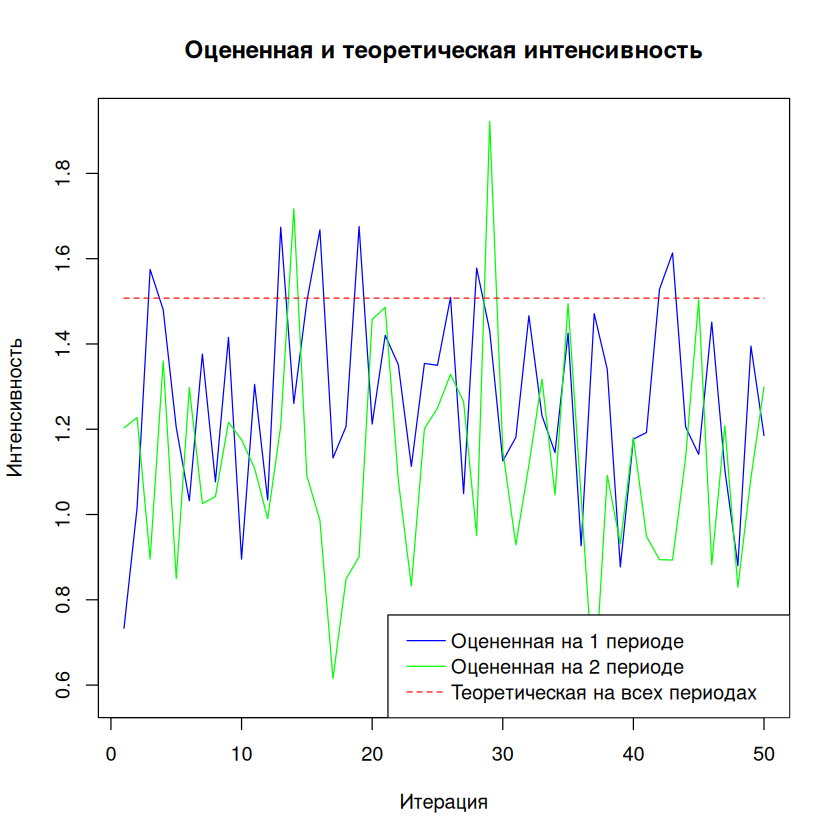

In [22]:
min_y <- min(min(rate$V1), min(rate$V2))
max_y <- max(max(rate$V1), max(rate$V2))

plot(rate$V1, type = "l", col = "blue", ylim = c(min_y, max_y), 
     xlab = "Итерация", ylab = "Интенсивность", main = "Оцененная и теоретическая интенсивность")

lines(rate$V2, type = "l", col = "green")
# abline(h = lambda_mean_V, col = "red", lty = 2)
lines(lambda_mean_V, type = "l", col = "red", lty = 2)

legend("bottomright", legend = c("Оцененная на 1 периоде", "Оцененная на 2 периоде", "Теоретическая на всех периодах"),
       col = c("blue", "green", "red"), lty = c(1, 1, 2), x.intersp = .3)

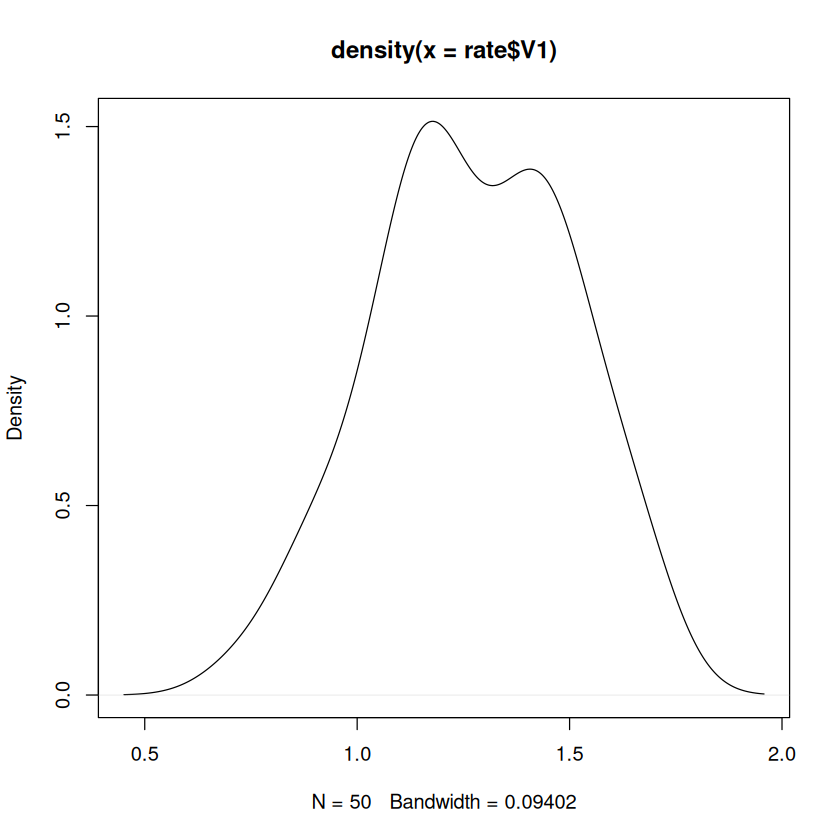

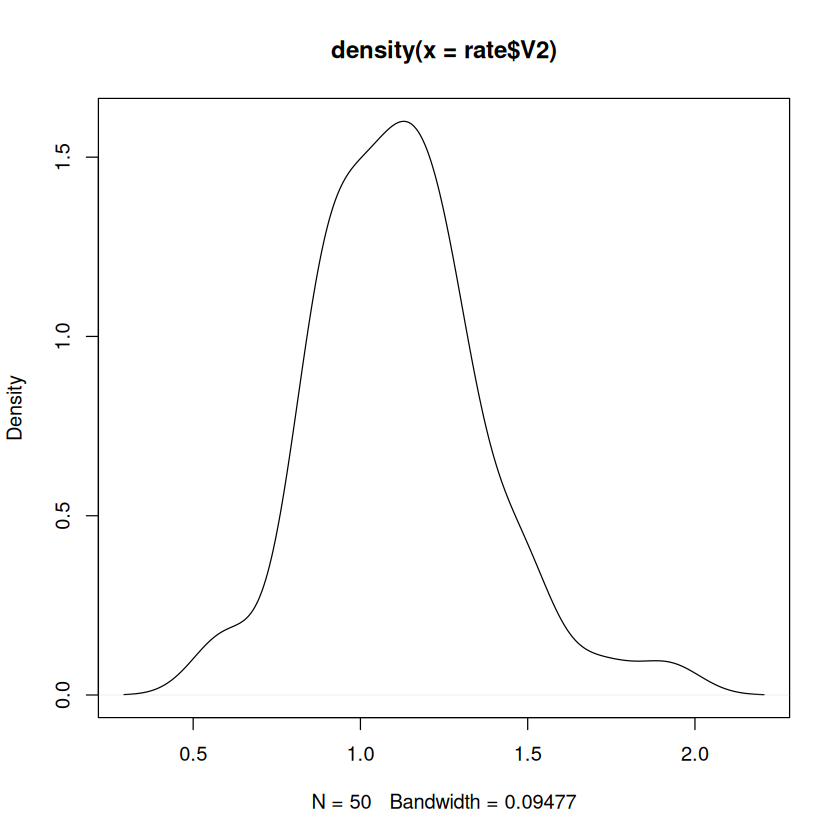

In [23]:
plot(density(rate$V1))
plot(density(rate$V2))

[1] 1.534723

[1] 1.5

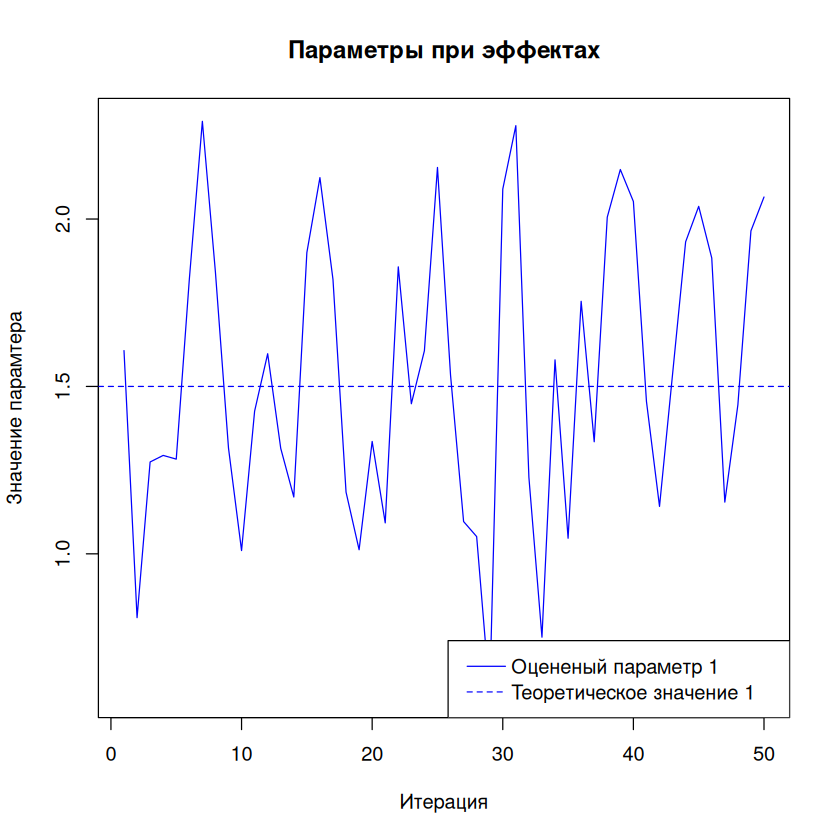

In [24]:
mean(teta$V1)
# mean(teta$V2)

beta$V1[1]
# beta$V2[1]


plot(teta$V1, type="l", col="blue", main = "Параметры при эффектах", xlab = "Итерация", ylab = "Значение парамтера",)
abline(h = beta$V1[1], col = "blue", lty = 2)
# abline(h = beta$V2[1],col = "green", lty = 2)
# lines(teta$V2, col = "green")

legend("bottomright", legend = c("Оцененый параметр 1", "Теоретическое значение 1 "),
       col = c("blue", "blue"), lty = c(1, 2), x.intersp = .3)



In [25]:
mean(teta$V1)
# mean(teta$V2)

[1] 1.534723

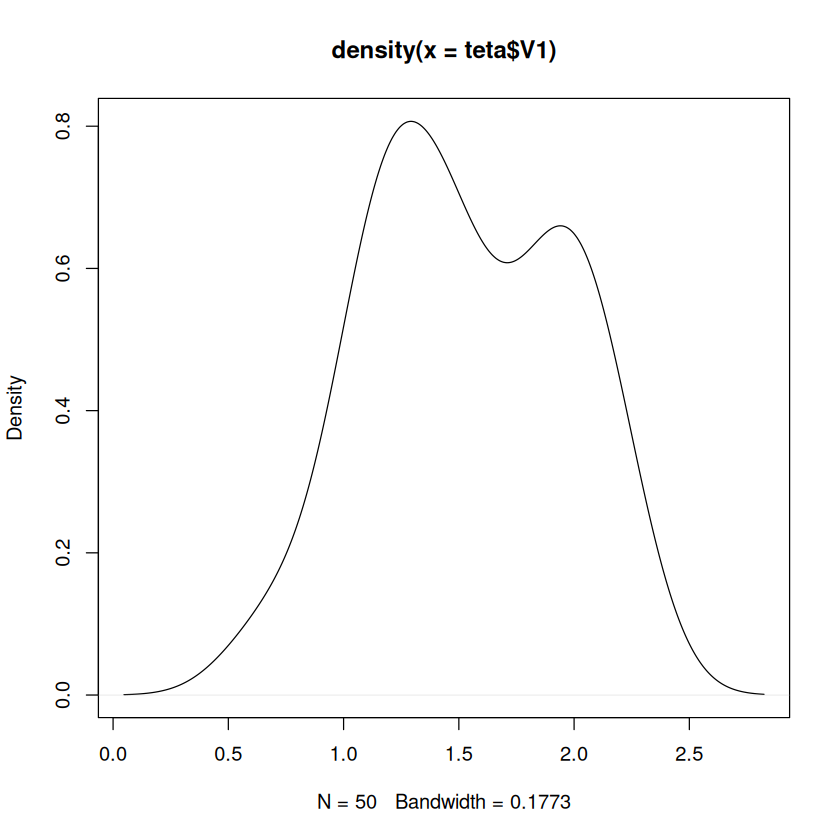

In [26]:
plot(density(teta$V1))
# plot(density(teta$V2))